In [3]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime,time

In [4]:
#importing dataset
df=pd.read_excel('Airlines+Data.xlsx')
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [6]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [7]:
df.shape

(96, 2)

In [8]:
df.isna().sum()

Month         0
Passengers    0
dtype: int64

In [9]:
df['Month']=pd.to_datetime(df['Month'],infer_datetime_format=True)
indexedDataset=df.set_index(['Month'])
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [11]:
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

# Visualizing the data showing elements of data

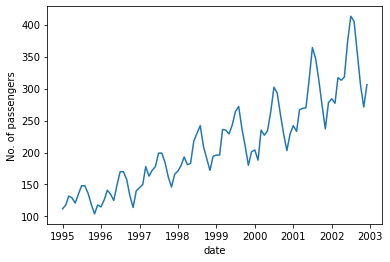

In [12]:
plt.xlabel('date')
plt.ylabel('No. of passengers')
plt.plot(indexedDataset)

In [14]:
rolmean=indexedDataset.rolling(window=12).mean()
rolstd=indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01  316.833333
2002-09-01  320.416667
2002-10-01  323.083333
2002-11-01  325.916667
2002-12-01  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01   54.530781
2002-09-01   55.586883
2002-10-01   53.899668
2002-11-01   49.692616
2002-12-01   47.861780

[96 rows x 1 columns]


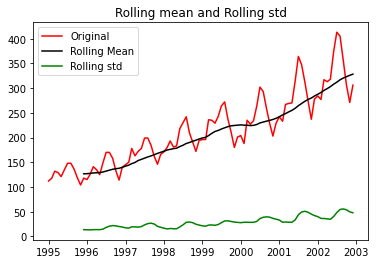

In [15]:
orig=plt.plot(indexedDataset,color='red',label='Original')
mean=plt.plot(rolmean,color='black',label='Rolling Mean')
std=plt.plot(rolstd,color='green',label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling mean and Rolling std')
plt.show(block=False)

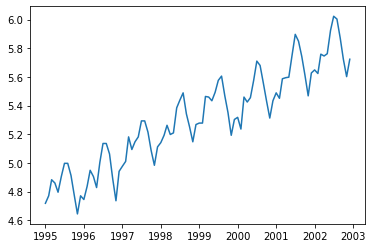

In [17]:
indexedDataset_logScale=np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

In [19]:
movingAverage=indexedDataset_logScale.rolling(window=12).mean()
movingSTD=indexedDataset_logScale.rolling(window=12).std()

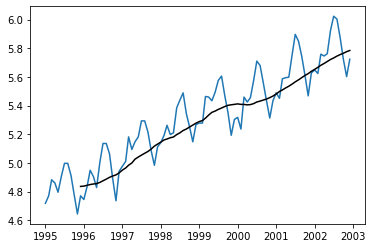

In [20]:
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage,color='black')

In [21]:
df1=indexedDataset_logScale-movingAverage
df1.head(5)

,Passengers
Month,
1995-01-01,NaN
1995-02-01,NaN
1995-03-01,NaN
1995-04-01,NaN
1995-05-01,NaN


In [22]:
df1.dropna(inplace=True)

In [23]:
df1.head(5)

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566
1996-03-01,0.099416
1996-04-01,0.052142


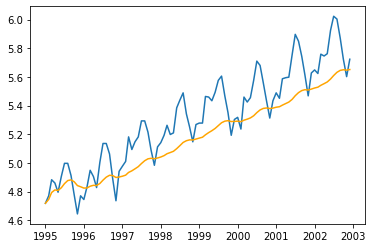

In [24]:
exponentialDecayWeightedAverage=indexedDataset_logScale.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage,color='orange')

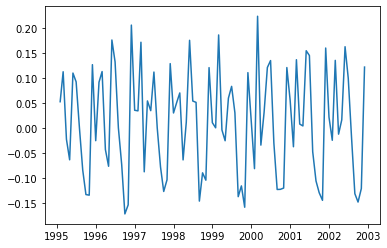

In [27]:
datasetLogScaleMinusMovingExponentDecayAverage = indexedDataset_logScale-exponentialDecayWeightedAverage
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

In [28]:
datasetLogDiffShifting[:3]

,Passengers
Month,
1995-01-01,NaN
1995-02-01,0.052186
1995-03-01,0.112117


In [29]:
datasetLogDiffShifting.dropna(inplace=True)
datasetLogDiffShifting[:3]

,Passengers
Month,
1995-02-01,0.052186
1995-03-01,0.112117
1995-04-01,-0.022990


# Building models with different types using visualization

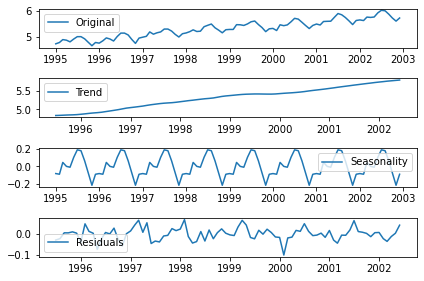

In [31]:
#Seprate trend,residual,sessionality from data
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label = "Original")
plt.legend(loc = "best")

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc = 'best')
plt.tight_layout()
decompositionLogData = residual
decompositionLogData.dropna(inplace=True)

In [32]:
from statsmodels.tsa.stattools import acf,pacf

In [33]:
acf=acf(datasetLogDiffShifting,nlags=20)
pacf=pacf(datasetLogDiffShifting,nlags=20,method='ols')

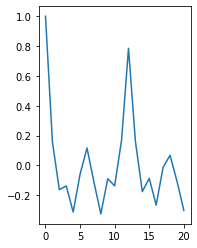

In [35]:
plt.subplot(121)
plt.plot(acf)

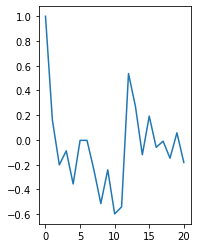

In [36]:
plt.subplot(122)
plt.plot(pacf)


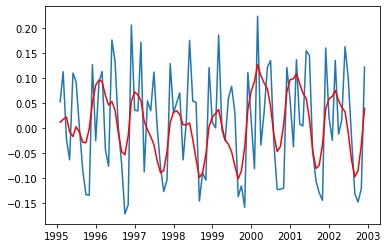

In [37]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(indexedDataset_logScale,order=(2,1,2))
results_AR=model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues,color='red')

In [38]:
predictions_ARIMA_diff=pd.Series(results_AR.fittedvalues,copy=True)

In [39]:
predictions_ARIMA_diff

Month
1995-02-01    0.011261
1995-03-01    0.016606
1995-04-01    0.021673
1995-05-01   -0.008098
1995-06-01   -0.017404
                ...   
2002-08-01   -0.064372
2002-09-01   -0.097877
2002-10-01   -0.085698
2002-11-01   -0.033980
2002-12-01    0.038843
Length: 95, dtype: float64

In [41]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum

Month
1995-02-01    0.011261
1995-03-01    0.027867
1995-04-01    0.049540
1995-05-01    0.041442
1995-06-01    0.024038
                ...   
2002-08-01    0.954121
2002-09-01    0.856245
2002-10-01    0.770547
2002-11-01    0.736567
2002-12-01    0.775411
Length: 95, dtype: float64

In [42]:
predictions_ARIMA_log=pd.Series(indexedDataset_logScale['Passengers'].iloc[0],index=indexedDataset_logScale.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

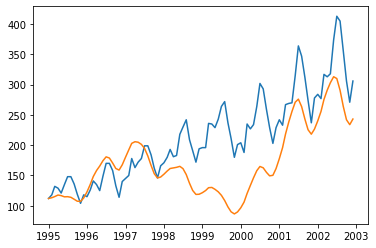

In [43]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

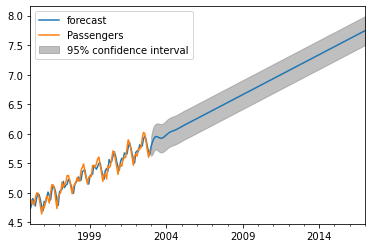

In [44]:
results_AR.plot_predict(1,264)
results=results_AR.forecast(steps=100)

In [45]:
results[1]

array([0.08322789, 0.10433389, 0.10879246, 0.10879587, 0.11129808,
       0.11615922, 0.12024408, 0.12204269, 0.1222865 , 0.12234938,
       0.12286454, 0.12359406, 0.12410625, 0.1242817 , 0.12428978,
       0.12431921, 0.12441646, 0.1245226 , 0.12458257, 0.1245965 ,
       0.12459655, 0.12460567, 0.12462354, 0.12463909, 0.12464618,
       0.12464723, 0.12464741, 0.12464919, 0.12465174, 0.1246535 ,
       0.12465405, 0.12465406, 0.12465423, 0.12465471, 0.12465522,
       0.12465552, 0.12465562, 0.12465562, 0.12465563, 0.12465567,
       0.1246557 , 0.12465571, 0.12465571, 0.12465572, 0.12465574,
       0.12465577, 0.1246558 , 0.12465581, 0.12465582, 0.12465582,
       0.12465582, 0.12465582, 0.12465582, 0.12465583, 0.12465583,
       0.12465584, 0.12465585, 0.12465585, 0.12465586, 0.12465587,
       0.12465587, 0.12465587, 0.12465588, 0.12465588, 0.12465589,
       0.12465589, 0.1246559 , 0.1246559 , 0.12465591, 0.12465591,
       0.12465592, 0.12465592, 0.12465593, 0.12465593, 0.12465

In [46]:
len(results[1])

100